In [ ]:
import pandas as pd
import re
from collections import defaultdict

# Load the dataset from the CSV file
file_path = 'TWITTER+youtube(ML Project).csv'
column_name = 'Tweet'
df = pd.read_csv(file_path, encoding='latin1')

# Initialize a dictionary to store the short form frequencies
short_form_dict = defaultdict(int)

# Define a function to check if a word is a potential English short form
def is_potential_short_form(word):
    # Replace this with your logic for identifying potential English short forms
    # For this example, we'll assume that any word with at least 2 characters is a potential short form.
    return len(word) == 4

# Iterate through each row in the 'Tweet' column
for tweet in df[column_name]:
    # Tokenize the text into words and convert to lowercase
    words = re.findall(r'\w+', tweet.lower())

    # Iterate through the words and check if they are potential English short forms
    for word in words:
        if is_potential_short_form(word):
            short_form_dict[word] += 1

# Sort the short forms by frequency in descending order
sorted_short_forms = sorted(short_form_dict.items(), key=lambda item: item[1], reverse=True)

# Print the sorted short forms with their frequencies
for short_form, frequency in sorted_short_forms:
    print(f'{short_form}: {frequency}')


In [ ]:
pip install nltk

## Cleaning Hindi Text

In [ ]:
import re

def clean_hindi_text(text):
    # Define a regular expression pattern to match Hindi characters
    hindi_pattern = re.compile(r'[ऀ-ॿ\s]+')

    # Use the pattern to filter out non-Hindi characters
    cleaned_text = ''.join(hindi_pattern.findall(text))

    return cleaned_text

# Example text
input_text = "{'hi': 'अकॉर्डिंग तो माई माथर\nपूरी दुन्या मई कोरोना वायरस मेरे नैल पैंट लगनई से आयाã°â\x9fâ\x99â\x83\nऔर सबको लगता था सब चीना का किया हुवा है.ã°â\x9fâ\x98â\x85ã¢â\x9câ\x8cã¯â¸â\x8f'}"

# Clean the text
cleaned_text = clean_hindi_text(input_text)
print(cleaned_text)


 अकॉर्डिंग तो माई माथर
पूरी दुन्या मई कोरोना वायरस मेरे नैल पैंट लगनई से आया
और सबको लगता था सब चीना का किया हुवा है


In [ ]:
import pandas as pd
import re
from google.colab import files

# Define the cleaning function
def clean_hindi_text(text):
    # Define a regular expression pattern to match Hindi characters and Devanagari numbers
    hindi_pattern = re.compile(r'[ऀ-ॿ\s]+')
    devanagari_number_pattern = re.compile(r'[०-९]+')
    # Use the pattern to filter out non-Hindi characters
    cleaned_text = ' '.join(hindi_pattern.findall(text)) + ' '.join(devanagari_number_pattern.findall(text))
    return cleaned_text

# Load the dataset from your .xlsx file
input_file = "Translated_Dataset.xlsx"
df = pd.read_excel(input_file)

# Apply the cleaning function to a specific column in your DataFrame
column_to_clean = "transliterated_text"  # Replace with the actual column name
df['Cleaned_Column'] = df[column_to_clean].apply(clean_hindi_text)

# Save the processed data to a new Excel file
output_file = "cleaned_dataset.xlsx"
df.to_excel(output_file, index=False)

# Download the cleaned dataset
files.download(output_file)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Word Cloud for the Hindi Text

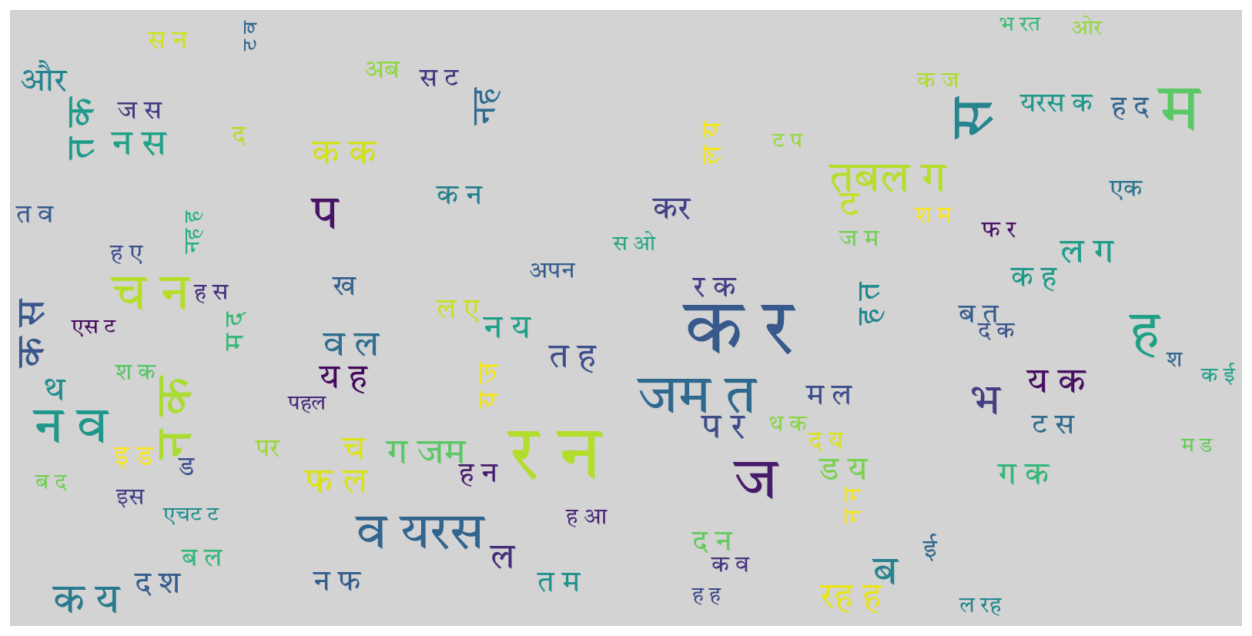

In [ ]:
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

# Function to tokenize the cleaned Hindi text
def tokenize_hindi_text(cleaned_text):
    # Tokenize the cleaned Hindi text using spaces
    tokenized_text = cleaned_text.split()
    return tokenized_text

# Specify the path to your Devanagari font file
font_path = "TiroDevanagariHindi-Regular.ttf"  # Replace with the actual path to your font

# Load the dataset from your .xlsx file
input_file = "cleaned_dataset.xlsx"  # Replace with your file path
df = pd.read_excel(input_file)

# Apply the cleaning function to a specific column in your DataFrame
column_to_clean = "Cleaned_Column"  # Replace with the column name containing cleaned Hindi text
df['cleaned_text'] = df[column_to_clean].apply(tokenize_hindi_text)

# Flatten the tokenized text to create a list of all words
tokenized_text = [word for tokens in df['cleaned_text'] for word in tokens]

# Create a WordCloud object with the specified font path
wordcloud = WordCloud(
    width=1600, height=800, background_color='lightgray',
    max_font_size=100, max_words=100, font_path=font_path
).generate(' '.join(tokenized_text))

# Display the Word Cloud
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# Save the word cloud image as a .png file
plt.savefig("hindi_wordcloud.png", format="png")

plt.show()


## Embeddings

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel

# Load the dataset from your .xlsx file
input_file = "cleaned_dataset.xlsx"
df = pd.read_excel(input_file)

# Specify the column name containing the text
column_to_process = "Cleaned_Column"
text_data = df[column_to_process]

# Load mBERT-large tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
model = AutoModel.from_pretrained("bert-base-multilingual-cased")

# Define a function to extract embeddings
def get_sentence_embeddings(text):
    # Tokenize the text
    tokens = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    # Forward pass through the model
    with torch.no_grad():
        output = model(**tokens)
    # Extract the embeddings from the output
    embeddings = output.last_hidden_state.mean(dim=1)  # You can use other pooling strategies as well
    return embeddings

# Calculate embeddings for the text data
embeddings_list = []
for text in text_data:
    embeddings = get_sentence_embeddings(text)
    embeddings_list.append(embeddings)

# Convert the list of embeddings to a single tensor
all_embeddings = torch.cat(embeddings_list)

# Save the embeddings as a PyTorch tensor
torch.save(all_embeddings, "embeddings.pt")

print("Embeddings saved as embeddings.pt")


Embeddings saved as embeddings.pt


## Model

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split

# Load the dataset from your .xlsx file
input_file = "cleaned_dataset.xlsx"  # Replace with your file path
df = pd.read_excel(input_file)

# Load embeddings from "embeddings.pt"
all_embeddings = torch.load("embeddings.pt")

# Prepare the labels
labels_fake = torch.tensor(df['Fake'].values)
labels_hate = torch.tensor(df['Hate'].values)

# Split the data into train and test sets
train_embeddings, test_embeddings, train_labels_fake, test_labels_fake, train_labels_hate, test_labels_hate = train_test_split(all_embeddings, labels_fake, labels_hate, test_size=0.2, random_state=42)



In [ ]:
# Define a custom dataset
class MultiTaskDataset(Dataset):
    def __init__(self, embeddings, labels_fake, labels_hate):
        self.embeddings = embeddings
        self.labels_fake = labels_fake
        self.labels_hate = labels_hate

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels_fake[idx], self.labels_hate[idx]

# Create data loaders for training and testing
train_dataset = MultiTaskDataset(train_embeddings, train_labels_fake, train_labels_hate)
test_dataset = MultiTaskDataset(test_embeddings, test_labels_fake, test_labels_hate)

batch_size = 32  # Set your batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define the multi-task classification model
class MultiTaskModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()  # Corrected super() call
        self.fake_classifier = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.hate_classifier = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, embeddings):
        fake_logits = self.fake_classifier(embeddings)
        hate_logits = self.hate_classifier(embeddings)

        return fake_logits, hate_logits


# Initialize and train the multi-task model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiTaskModel(all_embeddings.shape[1])
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 5  # Set the number of training epochs
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        embeddings, labels_fake, labels_hate = [x.to(device) for x in batch]

        fake_logits, hate_logits = model(embeddings)

        loss_fake = criterion(fake_logits.view(-1), labels_fake.float())
        loss_hate = criterion(hate_logits.view(-1), labels_hate.float())

        loss = loss_fake + loss_hate

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluation on the test set
    model.eval()
    with torch.no_grad():
        # Calculate metrics for both fake and hate detection
        fake_preds, hate_preds = [], []
        for batch in test_loader:
            embeddings, _, _ = [x.to(device) for x in batch]

            fake_logits, hate_logits = model(embeddings)
            fake_preds.extend(torch.sigmoid(fake_logits).cpu().numpy())
            hate_preds.extend(torch.sigmoid(hate_logits).cpu().numpy())

    # Calculate the metrics for each task
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    # Define a function to calculate metrics
    def calculate_metrics(y_true, y_pred, task_name):
      y_true = np.array(y_true).astype(int)
      y_pred = (np.array(y_pred) >= 0.5).astype(int)

      accuracy = accuracy_score(y_true, y_pred)
      precision = precision_score(y_true, y_pred)
      recall = recall_score(y_true, y_pred)
      f1 = f1_score(y_true, y_pred)

      print(f"{task_name} Metrics:")
      print(f"Accuracy: {accuracy:.4f}")
      print(f"Precision: {precision:.4f}")
      print(f"Recall: {recall:.4f}")
      print(f"F1 Score: {f1:.4f}\n")


# Calculate metrics for fake detection
calculate_metrics(np.array(test_labels_fake), fake_preds, "Fake Detection")

# Calculate metrics for hate detection
calculate_metrics(np.array(test_labels_hate), hate_preds, "Hate Detection")



Fake Detection Metrics:
Accuracy: 0.8467
Precision: 0.8467
Recall: 1.0000
F1 Score: 0.9170

Hate Detection Metrics:
Accuracy: 0.7767
Precision: 0.7848
Recall: 0.9021
F1 Score: 0.8393



## Saving the Model

In [ ]:
# Save the trained model
model_path = "multi_task_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


Model saved to multi_task_model.pth
